In [1]:
# Required moduls
import cv2
import numpy
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
import imutils
import numpy as np
from skimage.filters import frangi
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat') 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


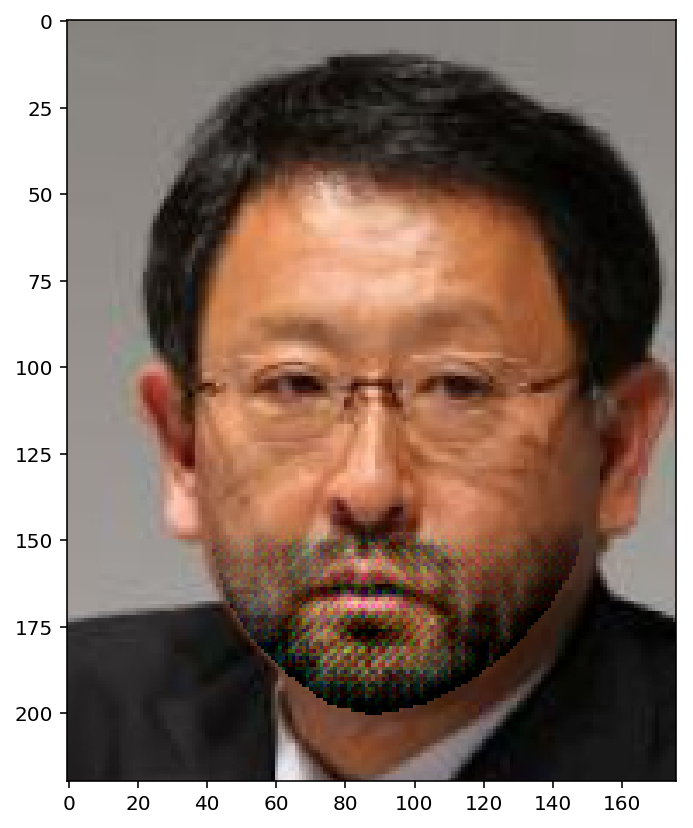

In [12]:
def apply_cropped_mask(image_dims=(176,220),
                       original_img_dir="data/val/yes_attribute",
                       original_img_name="170605.jpg",
                       mask_name = "170605_mask.npy",
                       mask_dir = "data/numpy_masks",
                       phase_pixels=10,
                       output_dir="data/postprocess_imgs"):
    
    img_import = cv2.imread(original_img_dir+"/"+original_img_name)
    img2rgb = cv2.cvtColor(img_import, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img2rgb, image_dims)
    
    # Import original image and resize
    img = cv2.imread(original_img_dir+"/"+original_img_name)
    img = cv2.resize(img, image_dims)

    h, w, ch = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # add an alpha channel to image
    b,g,r = cv2.split(img);
    a = np.ones((h,w,1), np.uint8) * 255
    img = cv2.merge((b, g, r, a))

    # detect face
    rects = detector(gray,1)
    roi = rects[0] # region of interest
    shape = predictor(gray, roi)
    shape = face_utils.shape_to_np(shape)

    # extract jawline
    jawline = shape[0:17]
    top = min(jawline[:,1])
    bottom = max(jawline[:,1])

    # extend contour for masking
    jawline = np.append(jawline, [ w-1, jawline[-1][1] ]).reshape(-1, 2)
    jawline = np.append(jawline, [ w-1, h-1 ]).reshape(-1, 2)
    jawline = np.append(jawline, [ 0, h-1 ]).reshape(-1, 2)
    jawline = np.append(jawline, [ 0, jawline[0][1] ]).reshape(-1, 2)
    contours = [ jawline ]

    # generate mask
    mask = np.ones((h,w,1), np.uint8) * 255 # times 255 to make mask 'showable'
    cv2.drawContours(mask, contours, -1, 0, -1) # remove below jawline

    # apply to image
    result = cv2.bitwise_and(img, img, mask = mask)

    # Identify landmark representing bottom of nose (and top of beard)
    top_of_beard = shape[31][1]

    # cut out face below nose and default all pixels to binary scale
    zoom_result = result[top_of_beard:][:,:,:3]
    zoom_result = np.clip(zoom_result, 0, 1).astype(np.float64)


    # Utility to create a smooth transition from beard to face above beard
    layers = phase_pixels # number of pixel layers to phase out
    for i in range(layers):
        penalty = (1/layers * i)
        zoom_result[i,:] = zoom_result[i,:] * penalty


    # load mask prediction output
    mask_import = np.load(mask_dir+"/"+mask_name)

    # Place binary mask cutout onto originally sized image
    mask_filter = np.zeros(mask_import.shape)
    mask_filter[top_of_beard:] = zoom_result

    # multiply binary mask cutout by true mask to create cropped mask
    cropped_mask = mask_import * mask_filter

    # Apply cropped mask to original image
    masked_input = (img_resize/255) + cropped_mask
    cv2.imwrite(output_dir+"/"+original_img_name[:-4]+"Final.jpg",
                (masked_input*255).astype(int)[:,:,::-1])
    
    plt.figure(figsize=(7,7))
    plt.imshow(masked_input)
    
apply_cropped_mask(original_img_dir="data/val/no_attribute",
                   original_img_name="163226.jpg",
                   mask_name = "163226_mask.npy",
                   mask_dir = "data/numpy_masks",
                   phase_pixels=8,
                   output_dir="data/postprocess_imgs")